<a href="https://colab.research.google.com/github/arminsoltan/mohaymen/blob/development/Phase02/Intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torchvision
import torch
from torchvision import transforms
import pandas as pd
import warnings
import os
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Resize, Normalize, RandomHorizontalFlip 
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [30]:
warnings.filterwarnings("ignore")

In [31]:
# !unzip "/content/drive/MyDrive/dataset/Intel.zip" -d "/content/"

In [32]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available")
else:
  print("CUDA is available")

CUDA is not available


In [33]:
# Hyper-parameters
batch_size = 28
learning_rate = 0.001


In [34]:
# transform = transforms.Compose[transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
train_dir = '/content/Intel/seg_train'
test_dir = '/content/Intel/seg_test'
outcomes = os.listdir(train_dir)
print(outcomes)

['glacier', 'forest', 'sea', 'mountain', 'buildings', 'street']


In [35]:
nums = {}
for outcome in outcomes:
  nums[outcome] = len(os.listdir(train_dir + '/' + outcome))
image_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
image_per_class

,no. of images
glacier,2404
forest,2271
sea,2274
mountain,2512
buildings,2191
street,2382


In [36]:
nums_test = {}
outcomes_test = os.listdir(test_dir)
for outcome in outcomes_test:
  nums_test[outcome] = len(os.listdir(test_dir + '/' + outcome))
test_image_per_class = pd.DataFrame(nums_test.values(), index=nums_test.keys(), columns=["no. of test images"])
test_image_per_class

,no. of test images
glacier,553
forest,474
sea,510
mountain,525
buildings,437
street,501


In [37]:
# from google.colab import drive
# drive.mount('/content/drive')

In [38]:
transform_train = transforms.Compose([Resize((224, 224)),
                                      RandomHorizontalFlip(),
                                      ToTensor(),
                                      Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_test = transforms.Compose([Resize((224, 224)),
                                     ToTensor(),
                                     Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [39]:
train_data = ImageFolder(root=train_dir, transform=transform_train)
test_data = ImageFolder(root=test_dir, transform=transform_test)

In [40]:
batch_size = 32
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [41]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [42]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


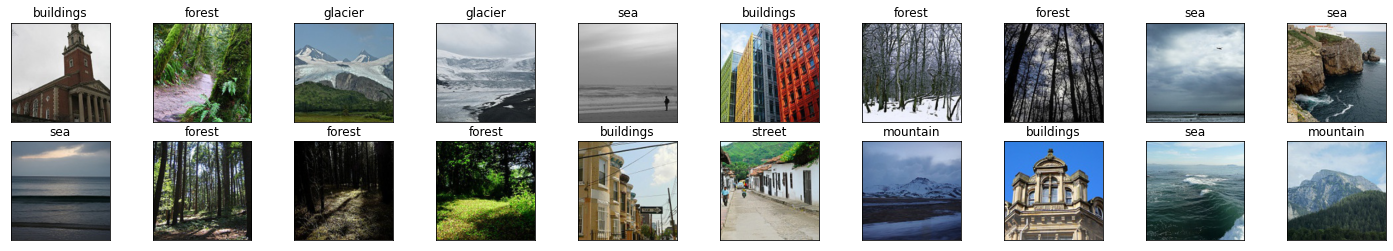

In [43]:
def imshow(image):
  image = image / 2 + 0.5
  plt.imshow(np.transpose(image, (1, 2, 0)))

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()
classes = list(nums.keys())
classes.sort()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [44]:
images, _ = dataiter.next()
print(images.shape)
conv1 = nn.Conv2d(3, 50, 3, padding=1)
conv2 = nn.Conv2d(50, 100, 3, padding=1)
conv3 = nn.Conv2d(100, 140, 3, padding=1)
conv4 = nn.Conv2d(140, 180, 3, padding=1)
conv5 = nn.Conv2d(180, 220, 3, padding=1)
fc1 = nn.Linear(220, 100)
fc2 = nn.Linear(100, 50)
fc3 = nn.Linear(50, 6)
pool1 = nn.MaxPool2d(3, 3)
pool2 = nn.MaxPool2d(2, 2)
x = pool1(conv1(images))
print(x.shape)
x = pool1(conv2(x))
print(x.shape)
x = pool1(conv3(x))
print(x.shape)
x = pool1(conv4(x))
print(x.shape)
x = pool2(conv5(x))
print(x.shape)

# conv4 = nn.Conv2d(140, 180, 3, padding=1)
# x = conv4(x)
# x = x.view(-1, 16 * 106 * 106)
# print(x.shape)


torch.Size([32, 3, 224, 224])
torch.Size([32, 50, 74, 74])
torch.Size([32, 100, 24, 24])
torch.Size([32, 140, 8, 8])
torch.Size([32, 180, 2, 2])
torch.Size([32, 220, 1, 1])


In [45]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 50, 3, padding=1)
    self.conv2 = nn.Conv2d(50, 100, 3, padding=1)
    self.conv3 = nn.Conv2d(100, 140, 3, padding=1)
    self.conv4 = nn.Conv2d(140, 180, 3, padding=1)
    self.conv5 = nn.Conv2d(180, 220, 3, padding=1)
    self.pool1 = nn.MaxPool2d(3, 3)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(220, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 6)
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.pool1(F.relu(self.conv3(x)))
    x = self.pool1(F.relu(self.conv4(x)))
    x = self.pool2(F.relu(self.conv5(x)))
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

In [46]:
PATH = "/content/state_dict_model.pt"

In [47]:
from tqdm import tqdm

model = ConvNet()

if train_on_gpu:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
schedular = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [48]:
num_epochs = 10
valid_loss_min = np.Inf

train_losses = []
valid_losses = []

In [49]:
model.train()
n_total_steps = len(train_dataloader)
for epoch in tqdm(range(num_epochs)):
  
  train_loss = 0.0
  valid_loss = 0.0

  for i, (images, labels) in enumerate(train_dataloader):

    if train_on_gpu:
      images, labels = images.cuda(), labels.cuda()

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.size(0)

  schedular.step()

  model.eval()
  for images, labels in valid_dataloader:
    if train_on_gpu:
      images, labels = images.cuda(), labels.cuda()
    
    outputs = model(images)

    loss = criterion(outputs, labels)

    valid_loss += loss.item() * images.size(0)

  # calculate average losses
  train_loss = train_loss / len(train_dataloader.sampler)
  valid_loss = valid_loss / len(valid_dataloader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.4f} \tValidation loss: {:.4f}'.format(
      epoch, train_loss, valid_loss
  ))

  if valid_loss <= valid_loss_min:
    valid_loss_min = valid_loss

  torch.save(model.state_dict(), PATH)


 10%|█         | 1/10 [19:33<2:56:00, 1173.42s/it]

Epoch: 0 	Training Loss: 1.7947 	Validation loss: 1.7919



 20%|██        | 2/10 [39:21<2:37:01, 1177.67s/it]

Epoch: 1 	Training Loss: 1.7936 	Validation loss: 1.7916



 30%|███       | 3/10 [59:10<2:17:48, 1181.25s/it]

Epoch: 2 	Training Loss: 1.7932 	Validation loss: 1.7914



 40%|████      | 4/10 [1:18:33<1:57:34, 1175.79s/it]

Epoch: 3 	Training Loss: 1.7928 	Validation loss: 1.7912


KeyboardInterrupt: ignored

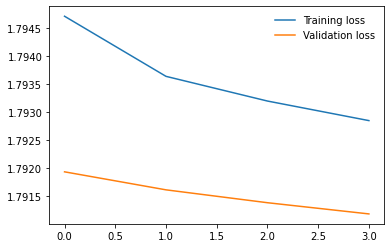

In [50]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [52]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model.eval()
for images, labels in test_dataloader:
  if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

  outputs = model(images)
  loss = criterion(outputs, labels)

  test_loss += loss.item() * images.size(0)
  _, pred = torch.max(outputs, 1)

  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  for i in range(6):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss / len(test_dataloader.dataset)
print('Test loss: {:.4f}\n'.format(test_loss))

for i in range(6):
  if class_total[i] > 0:
    print("Test accuracy of class {} is = {:.4f}".format(classes[i], 100 * class_correct[i] / class_total[i]))
  else:
    print("Test accuracy of class {} is = {:.4f}".format(classes[i], 0))

print("Test accuracy (Overall): {:.4f}".format(100 * np.sum(class_correct) / np.sum(class_total)))


Test loss: 1.7937

Test accuracy of class buildings is = 0.0000
Test accuracy of class forest is = 0.0000
Test accuracy of class glacier is = 0.0000
Test accuracy of class mountain is = 100.0000
Test accuracy of class sea is = 0.0000
Test accuracy of class street is = 0.0000
Test accuracy (Overall): 17.9078


In [ ]:
from sklearn import metrics
import seaborn as sns

classes = ("forest", "sea", "street", "mountain", "buildings", "glacier")
cf_matrix = metrics.confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn.metrics import f1_score, recall_score

